## Price Analysis

#### Imports

In [1]:
import sqlite3
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
from ipywidgets import interact, Dropdown, widgets
from IPython.display import clear_output
import seaborn as sns

#### Set up

In [2]:
def repo_root(start=None) -> Path:
    p = Path(start or Path.cwd()).resolve()
    while p != p.parent and not (p / ".git").exists():
        p = p.parent
    return p

ROOT = repo_root()
DB = (ROOT / "events.db").resolve()
print("DB:", DB, "| exists:", DB.exists(), "| size(bytes):", DB.stat().st_size if DB.exists() else 0)

DB: /Users/jillcusick/Desktop/MLDS-400/ticketmaster-data-collection/events.db | exists: True | size(bytes): 10706944


#### One-time Index Creation : add indexes to speeds up reads/filters/joins

In [3]:
CREATE_INDEXES = True  # set False if already done / no write perms needed
if CREATE_INDEXES:
    with sqlite3.connect(f"file:{DB}?mode=rw", uri=True) as con_rw:  # read-write, only if file exists
        con_rw.executescript("""
        CREATE INDEX IF NOT EXISTS ix_events_event_id    ON events(event_id);
        CREATE INDEX IF NOT EXISTS ix_events_datetime    ON events(datetime);
        CREATE INDEX IF NOT EXISTS ix_prices_event_date  ON event_price_history(event_id, snapshot_date);
        CREATE INDEX IF NOT EXISTS ix_prices_currency    ON event_price_history(currency);
        """)
        con_rw.commit()

#### Open read-only for all analysis

In [4]:
#con = sqlite3.connect(f"file:{DB}?mode=ro", uri=True)
con = sqlite3.connect(DB)
q = lambda sql, params=None: pd.read_sql(sql, con, params=params)

#### Pull events (only those with a scheduled datetime)

In [5]:
events = q("""
    SELECT event_id, name, type, segment, genre, subgenre, family,
           datetime, onsale_date, offsale_date, venue_id
    FROM events
    WHERE datetime IS NOT NULL
""")
for c in ["datetime", "onsale_date", "offsale_date"]:
    if c in events.columns:
        events[c] = pd.to_datetime(events[c], errors="coerce", utc=True).dt.tz_localize(None)
print("Events with scheduled datetime:", len(events))

Events with scheduled datetime: 9302


#### Pull price history filtered in SQL (USD, non-negative, pre-event)

In [6]:
pricedf = q("""
    SELECT e.event_id, e.name, e.type, e.segment, e.genre, e.subgenre, e.family,
           e.datetime, e.onsale_date, e.offsale_date, e.venue_id,
           p.snapshot_date, p.min_price, p.max_price, p.currency
    FROM events e
    JOIN (
        SELECT event_id, snapshot_date, min_price, max_price, currency
        FROM event_price_history
        WHERE currency='USD'
          AND min_price IS NOT NULL
          AND min_price >= 0
    ) p ON p.event_id = e.event_id
    WHERE e.datetime IS NOT NULL
      AND p.snapshot_date <= e.datetime
""")
for c in ["datetime", "onsale_date", "offsale_date", "snapshot_date"]:
    pricedf[c] = pd.to_datetime(pricedf[c], errors="coerce", utc=True).dt.tz_localize(None)
print("Price records after filtering:", len(pricedf))

Price records after filtering: 5302


#### Pull events by location

In [7]:
loc_events = q("""
    SELECT COUNT(DISTINCT e.event_id) AS event_count, v.lat, v.lon, v.city FROM events e
    JOIN venues v ON e.venue_id=v.venue_id 
    GROUP BY v.lat, v.lon, v.city
    ORDER BY event_count DESC
""")
loc_events.head()

,event_count,lat,lon,city
0,107,40.759017,-73.989686,New York
1,65,-37.790975,144.911911,Flemington
2,63,51.538590,-0.143343,London
3,56,40.730940,-74.000650,New York
4,50,36.102916,-115.169756,Las Vegas


#### Pull average max event price by location

In [8]:
#Average event price by location 
loc_avg_price = q('''
   SELECT v.venue_id,
       v.venue_name,
       v.city,
       v.state,
       v.lat,
       v.lon,
       AVG(p.max_price) AS avg_max_price,
       AVG(p.min_price) AS avg_min_price
FROM venues v
JOIN events e
  ON v.venue_id = e.venue_id
JOIN (
    SELECT event_id, min_price, max_price, currency
    FROM event_price_history
    WHERE currency = 'USD'
      AND min_price IS NOT NULL
      AND min_price >= 0
) p
  ON e.event_id = p.event_id
WHERE e.datetime IS NOT NULL
GROUP BY v.lat, v.lon, v.venue_id, v.venue_name, v.city, v.state
ORDER BY avg_max_price DESC''')

loc_avg_price.head()

,venue_id,venue_name,city,state,lat,lon,avg_max_price,avg_min_price
0,rZ7HnEZ17_SFS,Williams Center - Black Box - Rutherford,Rutherford,New Jersey,40.827110,-74.103330,979.099474,33.519474
1,rZ7HnEZ17a3qf,Gaslamp Long Beach,Long Beach,California,33.767095,-118.116275,580.775172,35.601724
2,rZ7HnEZ17fEAP,The Premier,Hickory,North Carolina,35.733424,-81.357256,547.090909,23.350000
3,rZ7HnEZ17oO1A,The Ritz,San Jose,California,37.330003,-121.885808,520.850000,31.814545
4,rZ7HnEZ17FaQ4,Whisky A Go Go,West Hollywood,California,34.090897,-118.385693,507.416129,39.015323


#### Pull event prices per genre for 10 most popular genres

In [9]:
genre_price = q('''
    SELECT e.event_id, e.genre, p.min_price, p.max_price FROM events e
    JOIN event_price_history p ON e.event_id=p.event_id
    WHERE p.currency = 'USD'
    AND p.min_price IS NOT NULL
    AND p.min_price >= 0
''')

#### Feature engineering in Python

In [10]:
# Cheapest price (first time it occurs) per event:
cheapest = (
    pricedf.dropna(subset=["min_price"])
           .sort_values(["event_id", "min_price", "snapshot_date"])
           .groupby("event_id", as_index=False)
           .first()[["event_id", "min_price", "snapshot_date"]]
           .rename(columns={"min_price": "cheapest_price",
                            "snapshot_date": "cheapest_seen_at"})
)

feat = (
    events.merge(cheapest, on="event_id", how="left")
          .assign(
              days_before_event=lambda d: (d["datetime"] - d["cheapest_seen_at"]).dt.days,
              month=lambda d: d["datetime"].dt.month,
              weekday=lambda d: d["datetime"].dt.day_name(),
              hour=lambda d: d["datetime"].dt.hour
          )
)

print(
    f"Events total: {len(events):,} | with cheapest observed: {feat['cheapest_price'].notna().sum():,}"
)

Events total: 9,302 | with cheapest observed: 1,365


#### Visualizations

In [11]:
from matplotlib.ticker import StrMethodFormatter

def as_currency(ax):
    ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

##### Distribution of cheapest prices

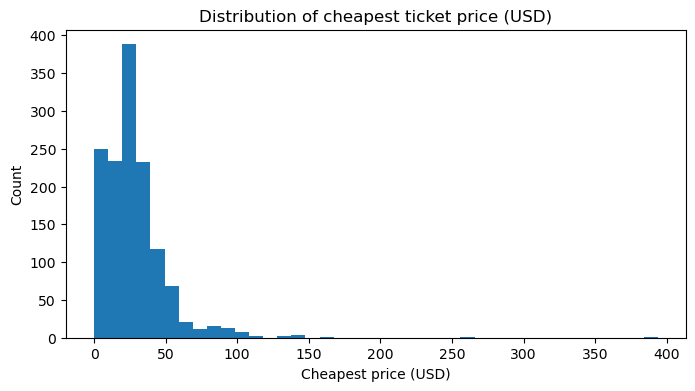

In [12]:
plt.figure(figsize=(8,4))
feat["cheapest_price"].dropna().plot(kind="hist", bins=40,
    title="Distribution of cheapest ticket price (USD)")
plt.xlabel("Cheapest price (USD)"); plt.ylabel("Count")
plt.show()

##### When is the cheapest price first observed? (lead-time histogram)

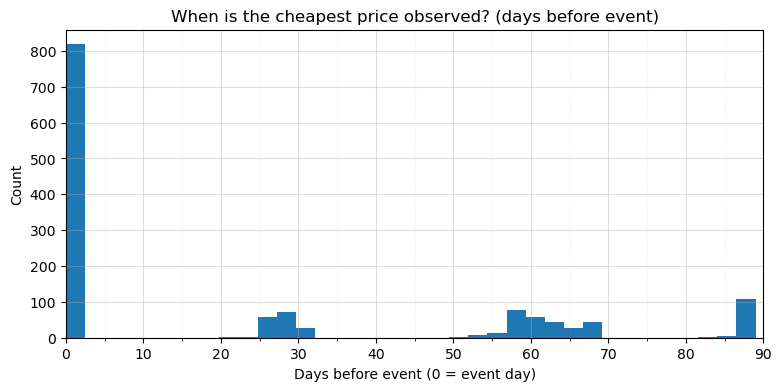

In [13]:
import matplotlib.ticker as mtick 

lead = feat["days_before_event"].dropna()
plt.figure(figsize=(9,4))
lead.clip(0, 180).plot(kind="hist", bins=36,
    title="When is the cheapest price observed? (days before event)")
plt.xlabel("Days before event (0 = event day)"); plt.ylabel("Count")

plt.xlim(0, 90)                                  # keep focus window
ax = plt.gca()
ax.xaxis.set_major_locator(mtick.MultipleLocator(10))   # ticks every 10 days
ax.xaxis.set_minor_locator(mtick.MultipleLocator(5))    # minor ticks every 5
ax.grid(True, which="major", alpha=0.4)
ax.grid(True, which="minor", alpha=0.2, linestyle=":")
plt.xticks(rotation=0)                             # keep labels horizontal
plt.show()

##### Median cheapest price by weekday/month

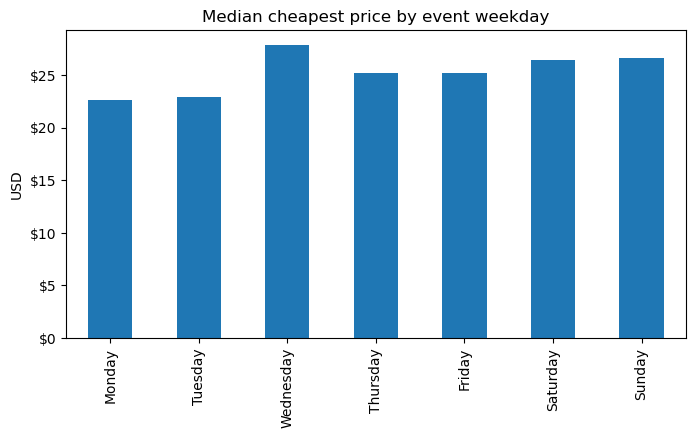

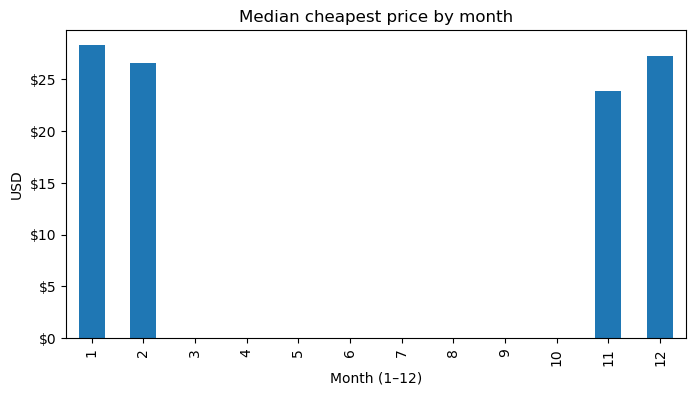

In [14]:
# Weekday
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
by_weekday = (feat.dropna(subset=["cheapest_price"])
                 .groupby("weekday")["cheapest_price"].median()
                 .reindex(weekday_order))
plt.figure(figsize=(8,4))
by_weekday.plot(kind="bar", title="Median cheapest price by event weekday")
plt.ylabel("USD"); plt.xlabel(""); as_currency(plt.gca()); plt.show()

# Month
by_month = (feat.dropna(subset=["cheapest_price"])
               .groupby("month")["cheapest_price"].median()
               .reindex(range(1,13)))
plt.figure(figsize=(8,4))
by_month.plot(kind="bar", title="Median cheapest price by month")
plt.ylabel("USD"); plt.xlabel("Month (1–12)"); as_currency(plt.gca()); plt.show()

##### Cheapest price vs lead time (scatter + rolling median)

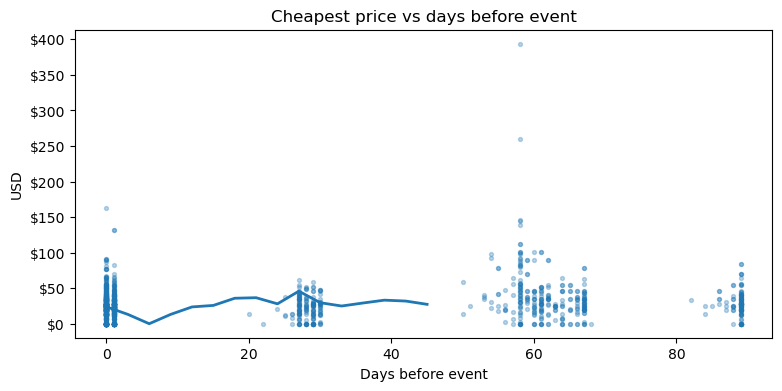

In [15]:
tmp = feat[["days_before_event", "cheapest_price"]].dropna()
plt.figure(figsize=(9,4))
plt.scatter(tmp["days_before_event"], tmp["cheapest_price"], s=8, alpha=0.3)
plt.title("Cheapest price vs days before event")
plt.xlabel("Days before event"); plt.ylabel("USD")

# rolling median across 3-day bins
grid = np.arange(0, max(1, int(tmp["days_before_event"].max()) + 1), 3)
med = (tmp.assign(bin=np.digitize(tmp["days_before_event"], grid))
          .groupby("bin")["cheapest_price"].median())
plt.plot(grid[:len(med)], med.values, linewidth=2)
as_currency(plt.gca())
plt.show()


##### Median cheapest by genre (top 10)

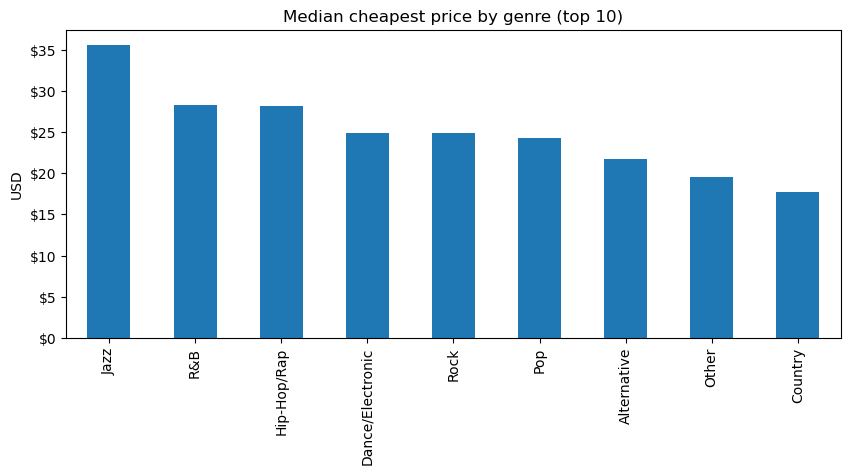

In [16]:
top_genre = feat["genre"].value_counts().head(10).index
by_genre = (feat[feat["genre"].isin(top_genre)]
              .dropna(subset=["cheapest_price"])
              .groupby("genre")["cheapest_price"].median()
              .sort_values(ascending=False))
plt.figure(figsize=(10,4))
by_genre.plot(kind="bar", title="Median cheapest price by genre (top 10)")
plt.ylabel("USD"); plt.xlabel(""); as_currency(plt.gca()); plt.show()

#### Box plot looking at distribution of cheapest event price by genre

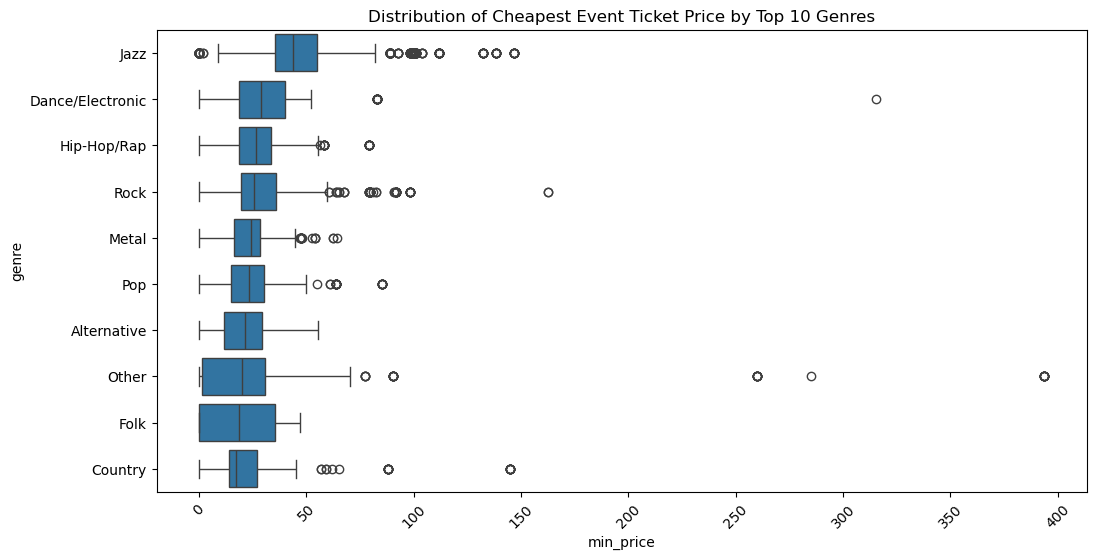

In [29]:
# Limit to top 10 genres by number of events
top_genres = (
    genre_price.groupby("genre")["event_id"]
    .nunique()   # count distinct events per genre
    .nlargest(10)
    .index
)

# Filter df to top 10 genres
filt_genre_price = genre_price[genre_price["genre"].isin(top_genres)]

# Computer median min_price per genre
median_order = (
    filt_genre_price.groupby("genre")["min_price"]
    .median()
    .sort_values(ascending=False)
    .index
)

# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x="min_price", y="genre", data=filt_genre_price,
            order=median_order)  # order by median min_price
plt.xticks(rotation=45)
plt.title("Distribution of Cheapest Event Ticket Price by Top 10 Genres")
plt.show()

##### Median cheapest price by state

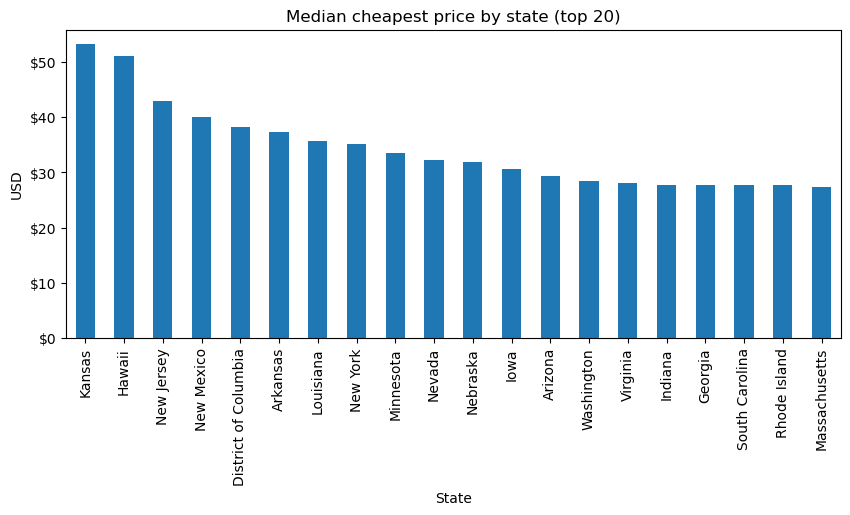

In [18]:
venues = q("SELECT venue_id, venue_name, city, state, country FROM venues;")
feat_geo = feat.merge(venues, on="venue_id", how="left")
by_state = (feat_geo.dropna(subset=["cheapest_price", "state"])
                    .groupby("state")["cheapest_price"].median()
                    .sort_values(ascending=False))
plt.figure(figsize=(10,4))
by_state.head(20).plot(kind="bar", title="Median cheapest price by state (top 20)")
plt.ylabel("USD"); plt.xlabel("State"); as_currency(plt.gca()); plt.show()

##### Deal window hit-rate: % of events whose cheapest price occurs within 5/15/30 days before the event.

In [19]:
def pct_within(days): 
    s = feat["days_before_event"].dropna()
    return float((s <= days).mean()) if len(s) else np.nan
print({
    "within_5d": pct_within(5),
    "within_15d": pct_within(15),
    "within_30d": pct_within(30),
})

{'within_5d': 0.5992673992673992, 'within_15d': 0.5992673992673992, 'within_30d': 0.7172161172161172}


##### Average price trajectory (not just cheapest): Plot the mean min_price across all events for each “days_before_event” k

<Figure size 900x400 with 0 Axes>

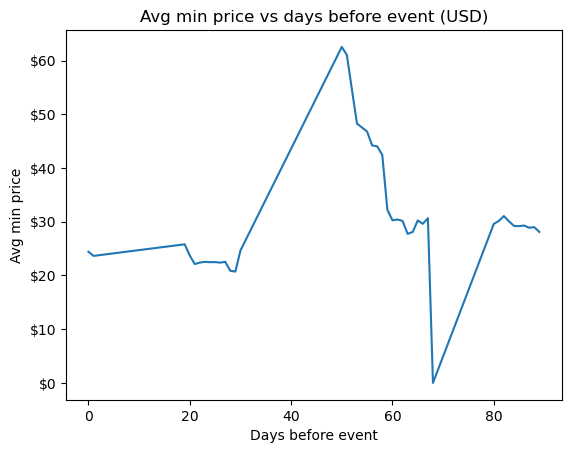

In [20]:
traj = pricedf.assign(
    days_before_event=(pricedf["datetime"] - pricedf["snapshot_date"]).dt.days
)
roll = (traj[traj["days_before_event"].between(0, 120)]
           .groupby("days_before_event")["min_price"]
           .mean().reset_index())
plt.figure(figsize=(9,4))
roll.plot(x="days_before_event", y="min_price", legend=False)
plt.title("Avg min price vs days before event (USD)")
plt.xlabel("Days before event"); plt.ylabel("Avg min price")
as_currency(plt.gca()); plt.show()

##### Price volatility per event: Number of distinct price levels observed; relate volatility to cheapest price.

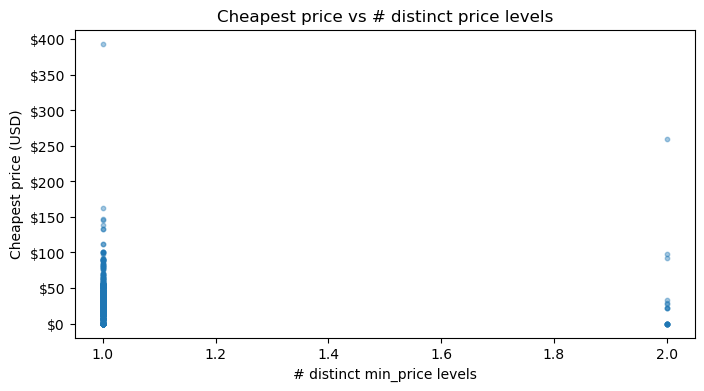

In [21]:
vol = (pricedf.sort_values(["event_id","snapshot_date"])
              .groupby("event_id")["min_price"].nunique()
              .rename("price_levels").reset_index())
feat2 = feat.merge(vol, on="event_id", how="left")
plt.figure(figsize=(8,4))
plt.scatter(feat2["price_levels"], feat2["cheapest_price"], s=10, alpha=0.4)
plt.title("Cheapest price vs # distinct price levels")
plt.xlabel("# distinct min_price levels"); plt.ylabel("Cheapest price (USD)")
as_currency(plt.gca()); plt.show()

##### On-sale timing vs price: Lead time from onsale_date to event and its relation to cheapest price.

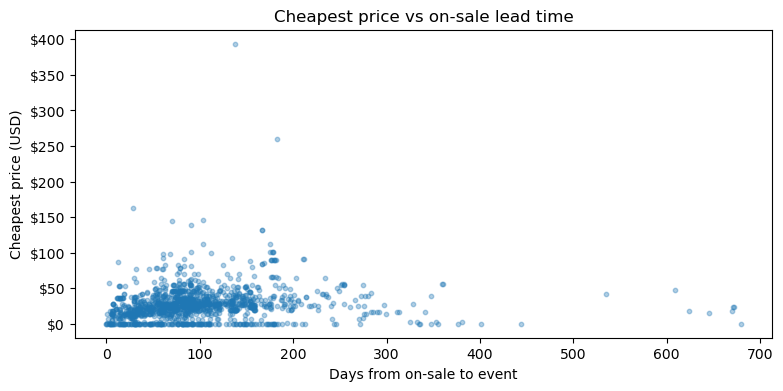

In [22]:
feat3 = feat.assign(
    onsale_lead_days=(feat["datetime"] - feat["onsale_date"]).dt.days
)
plt.figure(figsize=(9,4))
plt.scatter(feat3["onsale_lead_days"], feat3["cheapest_price"], s=10, alpha=0.35)
plt.title("Cheapest price vs on-sale lead time")
plt.xlabel("Days from on-sale to event"); plt.ylabel("Cheapest price (USD)")
as_currency(plt.gca()); plt.show()

##### Heat map of events in and around the US in next 90 days

In [23]:
fig = px.scatter_geo(loc_events,
                     lat="lat", lon="lon",
                     color="event_count", size="event_count",
                     scope="usa",
                     title="Number of Events in Next 90 Days by Location in/near US",
                     color_continuous_scale="Plasma",
                     width=1000,
                     height=700,
                     hover_data={
                     "event_count":":.2f",  # 2 decimal places
                     "lat":":.2f",
                     "lon":":.2f"})

fig.show()

##### Heat map of max event prices in and around the US in next 90 days

In [24]:
fig = px.scatter_geo(loc_avg_price,
                     lat="lat", lon="lon",
                     color="avg_max_price", size="avg_max_price",
                     scope="usa",
                     title="Average Event Max Ticket Price by Location in/near US",
                     color_continuous_scale="Plasma",
                     width=1000,
                     height=700,
                     hover_data={
                     "avg_max_price":":.2f",  # 2 decimal places
                     "lat":":.2f",
                     "lon":":.2f"})

fig.show()

In [25]:
# Dropdown options
artist_names = q("""
    SELECT DISTINCT a.artist_name
    FROM artists a
    JOIN events e ON a.artist_id = e.artist_id
    JOIN venues v ON e.venue_id = v.venue_id
    JOIN event_price_history p ON e.event_id = p.event_id
    WHERE a.artist_name IS NOT NULL
      AND p.currency = 'USD'
      AND p.min_price IS NOT NULL
      AND p.min_price >= 0
      AND e.datetime IS NOT NULL
    ORDER BY a.artist_name
""")["artist_name"].tolist()

artist_dropdown = widgets.Dropdown(
    options=artist_names,
    value=artist_names[0],
    description="Artist:",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="400px")
)

# Display the dropdown once
display(artist_dropdown)

# Create a separate output area for results
results_output = widgets.Output()
display(results_output)

def search_artist(artist_name):
    with results_output:
        clear_output(wait=True)
        print("Selected artist:", repr(artist_name))

        query = """
            SELECT v.venue_name, v.city, v.state,
                   AVG(p.min_price) AS avg_min_price,
                   AVG(p.max_price) AS avg_max_price
            FROM events e
            JOIN artists a ON e.artist_id = a.artist_id
            JOIN venues v ON e.venue_id = v.venue_id
            JOIN event_price_history p ON e.event_id = p.event_id
            WHERE LOWER(a.artist_name) = LOWER(?)
            AND p.min_price IS NOT NULL
            AND p.max_price IS NOT NULL
            AND p.min_price > 0
            AND p.max_price > 0
            GROUP BY v.venue_id, v.venue_name, v.city, v.state
            ORDER BY avg_min_price ASC
            LIMIT 10;
        """

        df = q(query, params=(artist_name,))
        print("Returned rows:", len(df))
        if df.empty:
            print("No venues found for this artist.")
        else:
            display(df.style.format({
                "avg_min_price": "${:.2f}",
                "avg_max_price": "${:.2f}"
            }))

def on_artist_change(change):
    if change['name'] == 'value' and change['new'] is not None:
        search_artist(change['new'])

artist_dropdown.observe(on_artist_change, names='value')

# Run once for the initial value
search_artist(artist_dropdown.value)


Dropdown(description='Artist:', layout=Layout(width='400px'), options=('156/Silence', '200 Stab Wounds', '70 L…

Output()

In [26]:

# --- Dropdown options ---
# Get distinct states that have venues + events + price history
state_names = q("""
    SELECT DISTINCT v.state
    FROM venues v
    JOIN events e ON v.venue_id = e.venue_id
    JOIN event_price_history p ON e.event_id = p.event_id
    WHERE v.state IS NOT NULL
      AND p.currency = 'USD'
      AND p.min_price IS NOT NULL
      AND p.min_price > 0
      AND p.max_price IS NOT NULL
      AND p.max_price > 0
      AND e.datetime IS NOT NULL
    ORDER BY v.state
""")["state"].tolist()

state_dropdown = widgets.Dropdown(
    options=state_names,
    value=state_names[0] if state_names else None,
    description="State:",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="300px")
)

city_dropdown = widgets.Dropdown(
    options=[],
    description="City:",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="300px")
)

venue_dropdown = widgets.Dropdown(
    options=[],
    description="Venue:",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="400px")
)

# Output area
results_output = widgets.Output()

# --- Functions ---
def update_cities(state):
    """Update city dropdown when state changes."""
    cities = q("""
        SELECT DISTINCT v.city
        FROM venues v
        JOIN events e ON v.venue_id = e.venue_id
        JOIN event_price_history p ON e.event_id = p.event_id
        WHERE v.state = ?
          AND v.city IS NOT NULL
          AND p.currency = 'USD'
          AND p.min_price IS NOT NULL
          AND p.min_price > 0
          AND p.max_price IS NOT NULL
          AND p.max_price > 0
          AND e.datetime IS NOT NULL
        ORDER BY v.city
    """, params=(state,))["city"].tolist()
    city_dropdown.options = cities
    city_dropdown.value = cities[0] if cities else None
    venue_dropdown.options = []
    venue_dropdown.value = None

def update_venues(city):
    """Update venue dropdown when city changes."""
    venues = q("""
        SELECT DISTINCT v.venue_name
        FROM venues v
        JOIN events e ON v.venue_id = e.venue_id
        JOIN event_price_history p ON e.event_id = p.event_id
        WHERE v.city = ?
          AND p.currency = 'USD'
          AND p.min_price IS NOT NULL
          AND p.min_price > 0
          AND p.max_price IS NOT NULL
          AND p.max_price > 0
          AND e.datetime IS NOT NULL
        ORDER BY v.venue_name
    """, params=(city,))["venue_name"].tolist()
    venue_dropdown.options = venues
    venue_dropdown.value = venues[0] if venues else None

def search_events(state, city, venue):
    """Query events for selected state + city + venue."""
    with results_output:
        clear_output(wait=True)
        print(f"Selected state: {state}, city: {city}, venue: {venue}")

        query = """
            SELECT a.artist_name,
                   e.datetime,
                   AVG(p.min_price) AS avg_min_price,
                   AVG(p.max_price) AS avg_max_price
            FROM events e
            JOIN artists a ON e.artist_id = a.artist_id
            JOIN venues v ON e.venue_id = v.venue_id
            JOIN event_price_history p ON e.event_id = p.event_id
            WHERE v.state = ?
              AND v.city = ?
              AND v.venue_name = ?
              AND p.currency = 'USD'
              AND p.min_price IS NOT NULL
              AND p.min_price > 0
              AND p.max_price IS NOT NULL
              AND p.max_price > 0
              AND e.datetime IS NOT NULL
            GROUP BY a.artist_name, e.datetime
            HAVING AVG(p.min_price) > 0
            ORDER BY avg_min_price ASC
            LIMIT 10;
        """

        df = q(query, params=(state, city, venue))
        print("Returned rows:", len(df))
        if df.empty:
            print("No events found for this venue.")
        else:
            display(df.style.format({
                "avg_min_price": "${:.2f}",
                "avg_max_price": "${:.2f}",
                "datetime": lambda x: x.strftime("%Y-%m-%d %H:%M") if hasattr(x, "strftime") else x
            }))

# --- Callbacks ---
def on_state_change(change):
    if change['name'] == 'value' and change['new'] is not None:
        update_cities(change['new'])

def on_city_change(change):
    if change['name'] == 'value' and change['new'] is not None:
        update_venues(change['new'])

def on_venue_change(change):
    if change['name'] == 'value' and change['new'] is not None:
        search_events(state_dropdown.value, city_dropdown.value, change['new'])

state_dropdown.observe(on_state_change, names='value')
city_dropdown.observe(on_city_change, names='value')
venue_dropdown.observe(on_venue_change, names='value')

# --- Display ---
display(state_dropdown, city_dropdown, venue_dropdown, results_output)

# Initialize cities/venues for the first state
if state_dropdown.value:
    update_cities(state_dropdown.value)
    if city_dropdown.value:
        update_venues(city_dropdown.value)
        if venue_dropdown.value:
            search_events(state_dropdown.value, city_dropdown.value, venue_dropdown.value)


Dropdown(description='State:', layout=Layout(width='300px'), options=('Alabama', 'Arizona', 'Arkansas', 'Calif…

Dropdown(description='City:', layout=Layout(width='300px'), options=(), style=DescriptionStyle(description_wid…

Dropdown(description='Venue:', layout=Layout(width='400px'), options=(), style=DescriptionStyle(description_wi…

Output()